### Will a customer purchase at least once in the next 3 days?

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter
# Modeling
from sklearn.preprocessing import LabelEncoder
# !pip install xgboost
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [4]:
casino = pd.read_csv("Online_casino_DIB.csv")
# Convert the timestamp column to datetime
casino.ReqTimeUTC = pd.to_datetime(casino.ReqTimeUTC)

# Remove timestamps outside the range
casino = casino[casino.ReqTimeUTC <='2020-02-29 00:00:00+00:00'].copy()
# Give new values to df column
casino.TransactionType = casino.TransactionType.map({'LOYALTYCARDDEBIT':'L2D', 'LOYALTYCARDCREDITCL':'L1D', 'LOYALTYCARDCREDIT':'L2W'})
# Filter df by condition 
casino = casino[(casino.TransactionType == "L2D") & (casino.Status=="APPROVED")].reset_index(drop=True)
# and remove single value columns
casino = casino[['AccountIdentifier', 'ReqTimeUTC', 'TransactionAmount']]
# Sort df by column values
casino = casino.sort_values(["AccountIdentifier", "ReqTimeUTC"]).reset_index(drop=True)
# Rename columns
casino.rename(columns = {'AccountIdentifier':'customer', 'ReqTimeUTC':'timest',  'TransactionAmount':'amount'}, inplace=True)
casino.head()

,customer,timest,amount
0,customer1,2019-03-01 17:24:43+00:00,30.0
1,customer1,2019-03-01 19:54:04+00:00,50.0
2,customer1,2019-03-01 22:44:15+00:00,40.0
3,customer1,2019-03-02 02:44:20+00:00,100.0
4,customer1,2019-03-02 18:28:39+00:00,25.0


In [5]:
casino.shape

(69734, 3)

### Problem framing
1. What could be the answer to our question: "will a customer purchase at least once in the next three days?"
2. Is this a time series/ supervised/ unsupervised learning problem?
3. What algorithms would be suitable for solving the problem?
4. What data do we need for solving this problem? (time-level: day)

### Feature engineering from transactional data

In [10]:
casino["day"] = casino.timest.dt.floor('D')
daily_activity = casino.groupby(["customer", "day"]).agg({"amount": ["sum", "count"]}).reset_index()
daily_activity = daily_activity.droplevel(axis=1, level=1)
daily_activity.columns = ["customer", "day", "daily_amount", "nr_trans"]
daily_activity

,customer,day,daily_amount,nr_trans
0,customer1,2019-03-01 00:00:00+00:00,120.0,3
1,customer1,2019-03-02 00:00:00+00:00,125.0,2
2,customer1,2019-03-03 00:00:00+00:00,200.0,2
3,customer1,2019-03-04 00:00:00+00:00,160.0,3
4,customer1,2019-03-05 00:00:00+00:00,240.0,3
...,...,...,...,...
28600,customer996,2019-03-14 00:00:00+00:00,25.0,1
28601,customer996,2019-09-13 00:00:00+00:00,25.0,2
28602,customer997,2019-09-22 00:00:00+00:00,50.0,1
28603,customer998,2019-11-09 00:00:00+00:00,50.0,2


In [25]:
full_customer_df = pd.DataFrame()
customer_ids = daily_activity.customer.unique()
len(customer_ids)

for customer in customer_ids:
    customer_df = daily_activity[daily_activity.customer == customer]
    customer_full_date_range = pd.date_range(
    customer_df.day.min(),
    customer_df.day.max(),
    freq = "D")
    customer_df = customer_df.set_index(keys = "day").copy()
    customer_df = customer_df.reindex(list(customer_full_date_range), fill_value=0)
    customer_df["customer"] = [customer]*len(customer_df)
    customer_df = customer_df.reset_index()

    full_customer_df = pd.concat([full_customer_df, customer_df])
full_customer_df = full_customer_df.reset_index(drop=True)
print(len(full_customer_df))


164656


In [46]:
ml_df = pd.DataFrame()
for customer in customer_ids:
    customer_df = full_customer_df[full_customer_df.customer==customer]
    customer_df = customer_df.reset_index(drop=True)

    features = []
    responses = []
    # Initial cutoff indices will be incremented
    x1, x14, y = 0, 14, 17

    while y<=len(customer_df):
        # Base
        feat_x1_x14 = customer_df.nr_trans[x1:x14].values.tolist()
        trans_next_3_days = np.count_nonzero(customer_df.nr_trans[x14:y])
        # response = [1 if trans_next_3_days!=0 else 0][0]
        response = [0 if trans_next_3_days!=0 else 1][0]
        responses.append(response)

        # Additional features
        ## -- Nr of days with money deposits in the last 14 days
        x15 = np.count_nonzero(customer_df.nr_trans[x1:x14])
        ## -- Nr of days with money deposits in the last 7 days
        x16 = np.count_nonzero(customer_df.nr_trans[x1+7:x14])
        ## -- Nr of days with money deposits in the last 3 days
        x17 = np.count_nonzero(customer_df.nr_trans[x14-2:x14+1])

        # Average number of deposits in the last 14 days
        x18 = customer_df.nr_trans[x1:x14].mean().tolist()
        # Max number of daily deposits in the last 14 days
        x19 = customer_df.nr_trans[x1:x14].max().tolist()


        # Amount deposited in the last 7 days
        x20 = customer_df.daily_amount[x1+7:x14].sum().tolist()
        # Average Daily Amount deposited in the last 7 days
        x21 = customer_df.daily_amount[x1+7:x14].mean().tolist()

        feat_x1_x14.extend([x15, x16, x17, x18, x19, x20, x21, customer])
        features.append(feat_x1_x14)

        # increment
        x1+=1
        x14+=1
        y+=1
    df = pd.DataFrame(features)
    df["response"]=responses 
    ml_df  = pd.concat([ml_df , df])

In [27]:
ml_df

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,response
0,3.0,2.0,2.0,3.0,3.0,4.0,2.0,2.0,3.0,0.0,...,0.0,9.0,2.0,1.0,1.714286,4.0,400.0,57.142857,customer1,1.0
1,2.0,2.0,3.0,3.0,4.0,2.0,2.0,3.0,0.0,0.0,...,3.0,9.0,2.0,2.0,1.714286,4.0,285.0,40.714286,customer1,1.0
2,2.0,3.0,3.0,4.0,2.0,2.0,3.0,0.0,0.0,0.0,...,1.0,9.0,2.0,3.0,1.642857,4.0,110.0,15.714286,customer1,1.0
3,3.0,3.0,4.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,...,2.0,9.0,3.0,2.0,1.642857,4.0,145.0,20.714286,customer1,0.0
4,3.0,4.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,3.0,1.0,1.428571,4.0,145.0,20.714286,customer1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,customer996,0.0
164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,customer996,0.0
165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,customer996,0.0
166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,customer996,0.0


Think about how to split for train and for test already.

Option #1: set aside some months for test and keep the rest for training
 
Option #2: split by customers

In [47]:
ml_df = ml_df.drop_duplicates(subset=list(range(20))).reset_index(drop=True)
print(len(ml_df))

54235


In [48]:
le = LabelEncoder()
ml_df.response = le.fit_transform(ml_df.response)

In [49]:
Counter(ml_df.response)
balanced_df = ml_df

In [50]:
# Split by customer id to prevent data leakage
split_df = balanced_df.iloc[:,[21, 22]].groupby(21).count().reset_index()
test_customers = list(split_df.sample(frac=0.2)[21])
test_customers[0:3]

['customer443', 'customer987', 'customer176']

In [51]:
test_df = balanced_df[balanced_df[21].isin(test_customers)]
train_df = balanced_df[~balanced_df[21].isin(test_customers)]
print(len(train_df))
print(Counter(train_df.response))
print(len(test_df))
print(Counter(test_df.response))

42809
Counter({0: 24406, 1: 18403})
11426
Counter({0: 7128, 1: 4298})


In [52]:
x_train = train_df.iloc[:, :21]
y_train = train_df.response
x_test = test_df.iloc[:, :21]
y_test = test_df.response

In [53]:
# Train the model
xgb_classifier = xgb.XGBClassifier(eta = 0.05)
xgb_classifier.fit(x_train, y_train)
print(xgb_classifier.score(x_train, y_train))
print(xgb_classifier.score(x_test, y_test))

0.7933612090915462
0.7842639593908629


In [54]:
# Predict
pred_labels = xgb_classifier.predict(x_test)
confusion_matrix(y_true = y_test, y_pred =pred_labels)

array([[5227, 1901],
       [ 564, 3734]])

In [55]:
tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred =pred_labels).ravel()
# print(tn, fp, fn, tp)

recall = tp/(tp+fn)
precision = tp/(tp+fp)
#miss rate/ FNR
false_negative_rate = fn/(tp+fn)
print(f"accuracy:{(tp+tn)/(len(y_test))}")
print(f"precision: {precision}")
print(f"recall:{recall}")
print(f"miss rate:{false_negative_rate}")

accuracy:0.7842639593908629
precision: 0.6626441881100266
recall:0.8687761749651001
miss rate:0.13122382503489996


In [56]:
# Create 5 folds
split_df = split_df.sample(frac=1).reset_index(drop=True)
K= 5
test_fold_size = int(len(split_df)/5)
folds = {
    0:{"train":[], "test":[]},
    1:{"train":[], "test":[]},
    2:{"train":[], "test":[]},
    3:{"train":[], "test":[]},
    4:{"train":[], "test":[]},}
end_idx = 0
for fold in range(K):
    start_idx = end_idx
    end_idx = end_idx+test_fold_size
    test_fold_df = split_df[start_idx: end_idx]
    test_fold_customers = list(set(test_fold_df[21]))
    train_fold_customers = list(set(split_df[21]) - set(test_fold_df[21]))
    folds[fold]["test"].append(test_fold_customers)
    folds[fold]["train"].append(train_fold_customers)
    print(len(test_fold_customers), len(train_fold_customers))
# folds

158 636
158 636
158 636
158 636
158 636


In [57]:
accuracies = []
precisions = []
recalls = []
miss_rates = []

for fold_id in folds.keys():
    print(fold_id)
    test_customers = folds[fold_id]["test"][0]
    train_customers = folds[fold_id]["train"][0]
    test_df = balanced_df[balanced_df[21].isin(test_customers)]
    train_df = balanced_df[balanced_df[21].isin(train_customers)]

    x_train = train_df.iloc[:, :21]
    y_train = train_df.response
    x_test = test_df.iloc[:, :21]
    y_test = test_df.response
    # Train the model
    xgb_classifier = xgb.XGBClassifier(eta = 0.05)
    xgb_classifier.fit(x_train, y_train)

    # Predict
    pred_labels = xgb_classifier.predict(x_test)
    confusion_matrix(y_true = y_test, y_pred =pred_labels)
    tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred =pred_labels).ravel()

    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    #miss rate/ FNR
    false_negative_rate = fn/(tp+fn)
    accuracy = (tp+tn)/(len(y_test))

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    miss_rates.append(false_negative_rate)

0
1
2
3
4


In [59]:
import seaborn as sns

<Axes: >

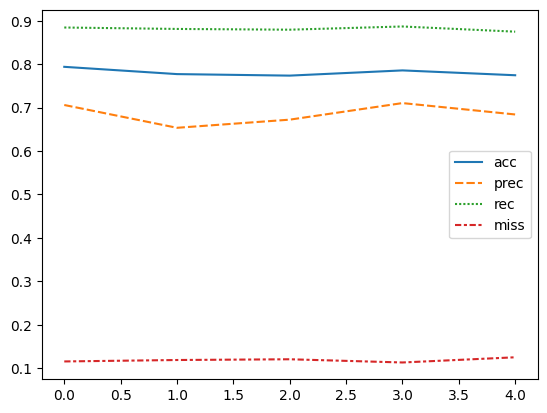

In [61]:
metrics = pd.DataFrame.from_dict({
    "acc":accuracies,
    "prec":precisions,
    "rec": recalls,
    "miss":miss_rates})
sns.lineplot(metrics)